<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [ ]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 

# ******************************** Hyper parameters ******************************** #


BATCH_SIZE = 3
NUM_EPOCHS = 15
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers


# *********************************** DataSet ************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)


def collate_timit(batch):
    # Get length for each sequence
    lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequence to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Separate input (x) and target (y)
    x = batch_padded[:,:,:-1]
    y = batch_padded[:,:,-1]  
    
    return x,y,lens

def collate_timit_reduce_target(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequence to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Separate input (x) and target (y)
    x = batch_padded[:,:,:-1]
    
    y_batch = [seq[:,-1] for seq in batch]
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch:
      diff = np.diff(y_seq).astype(np.bool)
      idx = np.insert(diff, 0, True)
      y_seq_reduced = y_seq[idx]
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))
      
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    y = torch.as_tensor(y_batch_padded)
    
    return x,y,lens,target_lens

# *********************************** Model ************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens

def greedy_decoding(sequences, sequence_lens, blank_label, remove_blanks=False):
  """
  For each timestemp, takes the label with maximum probability.

  :param sequences: torch tensor [batch, sequence len, number of classes]
  :param blank_label: blank label
  :param sequence_lens: list of sequence lengths for each sequence in batch
  :return: list of decoded sequences (differente lengths).
  """

  decoded_sequences = []
  for sequence, seq_len in zip(sequences, sequence_lens):
    seq = sequence[:seq_len]  # Remove pads
    decoded_seq = torch.argmax(seq, dim=1)

    if remove_blanks:
      decoded_seq = decoded_seq[decoded_seq != blank_label]


    decoded_sequences.append(decoded_seq)
  return decoded_sequences


def print_distances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

def levenshtein_distance(token1, token2, debug=False):
    """
    Computes the edit distance between two sequences.
    """
    distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    if debug:
      print_distances(distances, len(token1), len(token2))
    
    return distances[len(token1)][len(token2)]

def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist
    #print("distance: ", dist)

  #print('total distance:', total_distance)
  #print('target lens: ', target_lens)
  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)
  #print("label_err_rate", label_err_rate)

  return label_err_rate
  
def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      predictions = greedy_decoding(model_out, input_lens, blank_label=BLANK_LABEL, remove_blanks=True)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  #print("predictions ", predictions)
  #print("target data ", target_data)
  #print("label_err_rates ", label_err_rates)
  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit_reduce_target)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit_reduce_target)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919
Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



 ---- Training results ----
Loss: 1.3401699769935567
---- Test results ----
Loss: 1.2255169438819091
Label error rate: 1.0
Epoch nr:  2



 ---- Training results ----
Loss: 1.0567061509533877
---- Test results ----
Loss: 0.9075898093481859
Label error rate: 0.95129323522387
Epoch nr:  3



 ---- Training results ----
Loss: 0.7588778724208539
---- Test results ----
Loss: 0.6648162603378296
Label error rate: 0.727770464231156
Epoch nr:  4



 ---- Training results ----
Loss: 0.581417177340169
---- Test results ----
Loss: 0.5481127947568893
Label error rate: 0.5844366302593446
Epoch nr:  5



 ---- Training results ----
Loss: 0.4858870254708575
---- Test results ----
Loss: 0.48892263881862164
Label error rate: 0.5395738721758511
Epoch nr:  6



 ---- Training results ----
Loss: 0.43534284154380554
---- Test results ----
Loss: 0.456980362534523
Label error rate: 0.5229203018957679
Epoch nr:  7



 ---- Training results ----
Loss: 0.40184206222042895
---- Test results ----
Loss: 0.42688235205908615
Label error rate: 0.5254680431330754
Epoch nr:  8



 ---- Training results ----
Loss: 0.3770085873477387
---- Test results ----
Loss: 0.41130559736241895
Label error rate: 0.5158004030658733
Epoch nr:  9



 ---- Training results ----
Loss: 0.3573213188195383
---- Test results ----
Loss: 0.4051401649291317
Label error rate: 0.518868470602859
Epoch nr:  10



 ---- Training results ----
Loss: 0.34178789298642764
---- Test results ----
Loss: 0.39517606732745963
Label error rate: 0.506713854086691
Epoch nr:  11



 ---- Training results ----
Loss: 0.3293027083159654
---- Test results ----
Loss: 0.3937400647749503
Label error rate: 0.5065469156164852
Epoch nr:  12



 ---- Training results ----
Loss: 0.3178853865035556
---- Test results ----
Loss: 0.386829838467141
Label error rate: 0.49690588216573844
Epoch nr:  13



 ---- Training results ----
Loss: 0.3076521240142517
---- Test results ----
Loss: 0.3849663545067112
Label error rate: 0.4978069593032095
Epoch nr:  14



 ---- Training results ----
Loss: 0.2970993927159867
---- Test results ----
Loss: 0.38271100850154954
Label error rate: 0.4997297142437465
Epoch nr:  15



 ---- Training results ----
Loss: 0.2864247483173103
---- Test results ----
Loss: 0.3701577866449952
Label error rate: 0.48713648927809666


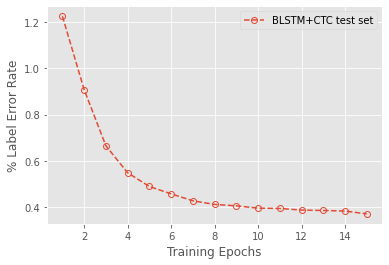

In [ ]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, losses, '--o', markerfacecolor='None', label='BLSTM+CTC test set')

# training_time = epoch_info['trainig_duration'][0]
ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/BLSTM/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'learning_curve_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()